# Demand Forecasting Model Training

This notebook trains time series models to predict material demand:
- ARIMA (AutoRegressive Integrated Moving Average)
- LSTM (Long Short-Term Memory)
- Prophet (Facebook's forecasting tool)
- Simple Moving Average (baseline)

## Approach
We'll compare multiple forecasting methods and select the best performing one.


In [ ]:
# Verify dependencies are available (all packages are installed system-wide in Python 3.12.12)
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

try:
    import pandas as pd
    import numpy as np
    import sklearn
    import matplotlib
    import seaborn as sns
    import torch
    print("✓ Core packages available!")
    print(f"  - pandas: {pd.__version__}")
    print(f"  - numpy: {np.__version__}")
    print(f"  - scikit-learn: {sklearn.__version__}")
    print(f"  - matplotlib: {matplotlib.__version__}")
    print(f"  - seaborn: {sns.__version__}")
    print(f"  - torch: {torch.__version__}")
    
    # Check optional packages
    try:
        import statsmodels
        print(f"  - statsmodels: {statsmodels.__version__}")
    except ImportError:
        print("  - statsmodels: ⚠️ Not installed (optional, for ARIMA)")
    
    try:
        import prophet
        print(f"  - prophet: {prophet.__version__}")
    except ImportError:
        print("  - prophet: ⚠️ Not installed (optional, for Prophet forecasting)")
        print("    Install with: python3 -m pip install prophet")
except ImportError as e:
    print(f"❌ Missing package: {e}")
    print("Run: python3 -m pip install <package_name>")


Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.0.13.3)]
Python executable: /usr/local/opt/python@3.12/bin/python3.12


✓ Core packages available!
  - pandas: 2.3.3
  - numpy: 1.26.4
  - scikit-learn: 1.7.2
  - matplotlib: 3.8.2
  - seaborn: 0.13.0
  - torch: 2.2.2
  - statsmodels: ⚠️ Not installed (optional, for ARIMA)
  - prophet: ⚠️ Not installed (optional, for Prophet forecasting)
    Install with: python3 -m pip install prophet


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set paths
BASE_DIR = Path('../')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models' / 'demand_forecaster'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")


Base directory: ..
Data directory: ../data
Models directory: ../models/demand_forecaster


## 1. Generate Sample Time Series Data


✓ Generated 90 days of demand data

First few rows:
        date  demand material_id
0 2024-01-01     102     MAT-001
1 2024-01-02     107     MAT-001
2 2024-01-03     113     MAT-001
3 2024-01-04     112     MAT-001
4 2024-01-05      95     MAT-001

Statistics:
count     90.000000
mean     109.111111
std       10.029669
min       85.000000
25%      103.000000
50%      108.000000
75%      115.000000
max      133.000000
Name: demand, dtype: float64


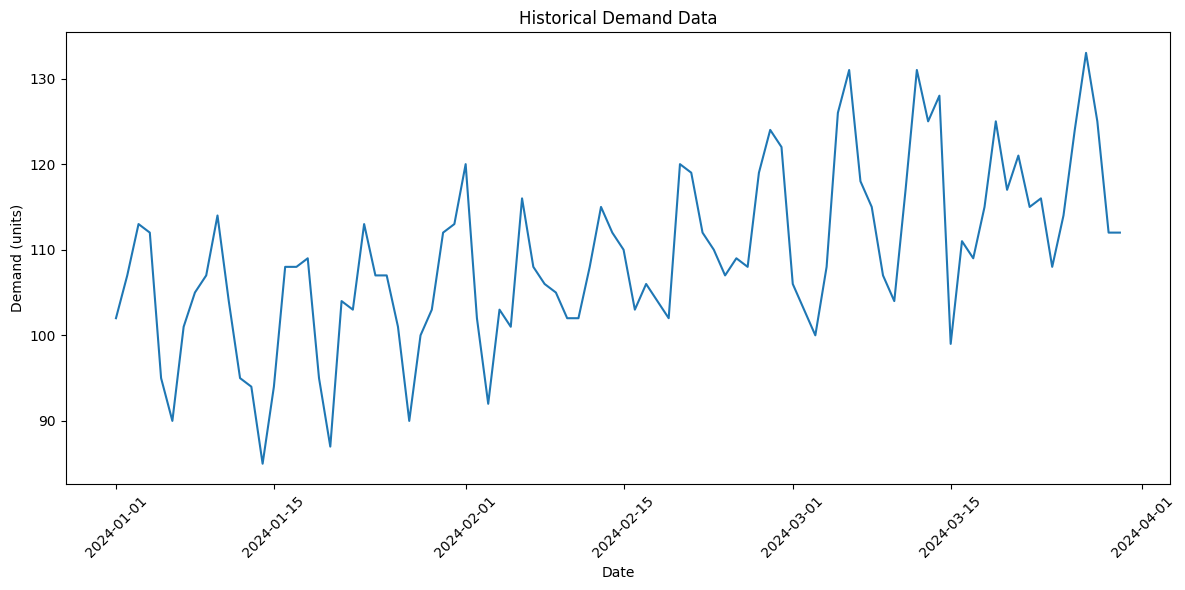

In [3]:
# Generate sample demand data (daily orders for 90 days)
dates = pd.date_range(start='2024-01-01', periods=90, freq='D')
np.random.seed(42)

# Create realistic demand pattern with trend and seasonality
base_demand = 100
trend = np.linspace(0, 20, 90)  # Increasing trend
seasonality = 10 * np.sin(2 * np.pi * np.arange(90) / 7)  # Weekly pattern
noise = np.random.normal(0, 5, 90)  # Random noise
demand = base_demand + trend + seasonality + noise
demand = np.maximum(demand, 0)  # No negative demand

df = pd.DataFrame({
    'date': dates,
    'demand': demand.astype(int),
    'material_id': 'MAT-001'
})

print(f"✓ Generated {len(df)} days of demand data")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nStatistics:")
print(df['demand'].describe())

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['demand'])
plt.title('Historical Demand Data')
plt.xlabel('Date')
plt.ylabel('Demand (units)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'demand_history.png')
plt.show()


## 2. Simple Moving Average Forecast


Last 7-day average: 118.29

7-day forecast:
        date    forecast
0 2024-03-31  118.285714
1 2024-04-01  118.285714
2 2024-04-02  118.285714
3 2024-04-03  118.285714
4 2024-04-04  118.285714
5 2024-04-05  118.285714
6 2024-04-06  118.285714


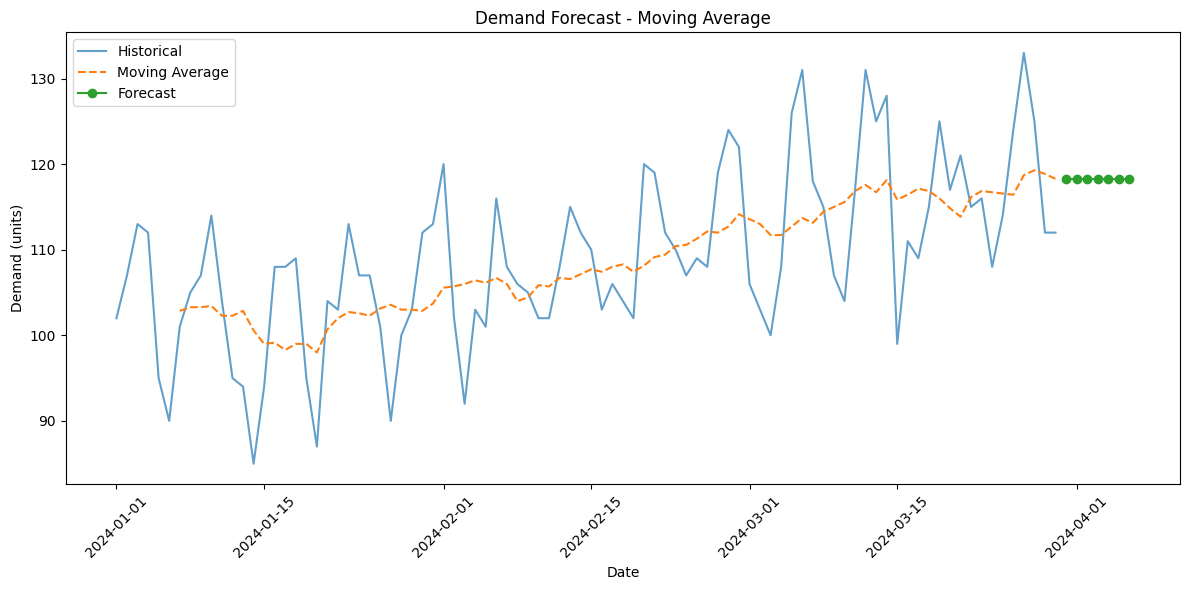


✓ Forecast saved to ../models/demand_forecaster


In [4]:
# Simple Moving Average (baseline)
window = 7  # 7-day moving average
df['ma_forecast'] = df['demand'].rolling(window=window).mean()

# Forecast next 7 days
last_avg = df['demand'].tail(window).mean()
forecast_dates = pd.date_range(start=df['date'].max() + timedelta(days=1), periods=7, freq='D')
forecast = pd.DataFrame({
    'date': forecast_dates,
    'forecast': [last_avg] * 7
})

print(f"Last {window}-day average: {last_avg:.2f}")
print(f"\n7-day forecast:")
print(forecast)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['demand'], label='Historical', alpha=0.7)
plt.plot(df['date'], df['ma_forecast'], label='Moving Average', linestyle='--')
plt.plot(forecast['date'], forecast['forecast'], label='Forecast', marker='o')
plt.title('Demand Forecast - Moving Average')
plt.xlabel('Date')
plt.ylabel('Demand (units)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'ma_forecast.png')
plt.show()

# Save forecast
forecast.to_csv(MODELS_DIR / 'ma_forecast.csv', index=False)
print(f"\n✓ Forecast saved to {MODELS_DIR}")
